<a href="https://colab.research.google.com/github/erlanggadewa/Sentiment-Analysis-Review-Steam/blob/roberta/roberta/transform/1e-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visit **ChrisMcCormickAI** on YouTube for more explanation.
[Image Reference](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=86C9objaKu8f)

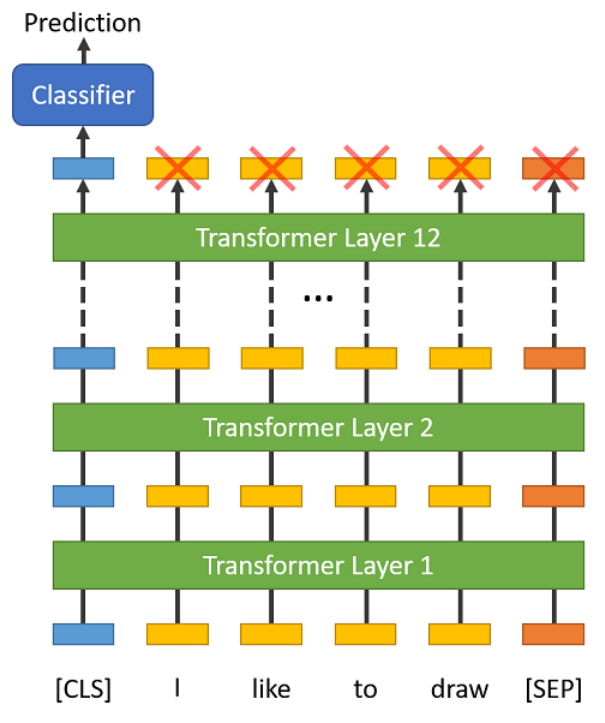

## **1. Cek resource**

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [2]:
!pip install transformers

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4d304c69d513eddfd91c800f1c3f0fbd5518e08057efb7ee1b9fa6f934286df5
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## **2. Download & load dataset**

In [4]:
import wget
import os

print("Downloading dataset...")

url = 'https://github.com/erlanggadewa/Sentiment-Analysis-Review-Steam/releases/download/production/gab-sentiment.csv'

if not os.path.exists('./dataset.csv'):
  wget.download(url, './dataset.csv')

In [5]:
import pandas as pd

df = pd.read_csv("./dataset.csv", delimiter=',')
df.shape

(10000, 3)

In [6]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the punkt_tab resource, which was likely missing
nltk.download('punkt_tab')


# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# 0. Convert to String
def convert_to_string(text):
    return str(text)

# 1. Punctuation Removal
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

# 2. Case Folding
def case_folding(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# 3. Stopword Removal and Lemmatization
def preprocess_text(text):
    word_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in word_tokens if word not in stop_words]
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Convert list of words back to string
    return ' '.join(lemmatized_words)

# Full preprocessing pipeline
def full_preprocessing(text):
    text = convert_to_string(text)
    text = remove_punctuation(text)
    text = case_folding(text)
    text = preprocess_text(text)  # Process text: remove stopwords and lemmatize
    return text

# Apply preprocessing to your dataframe
df["review"] = df["review"].apply(full_preprocessing)

# Save the final processed text to a CSV file
df.to_csv("clean-dataset.csv", index=False)
df = pd.read_csv("clean-dataset.csv", delimiter=",")
df.sample(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,label,sentiment,review
6224,Positive,1,dark soul 3 final soulslike game played played...
6664,Positive,1,ez one day depression tackle bos throw
4532,Negative,0,worst pc port game ever played far many basic ...
2259,Negative,0,really looking forward playing game sadly rele...
1614,Negative,0,really great moment mostly great game let recy...


<ipython-input-7-3638a25a03c5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#F55','#5A9'])  # Use countplot for direct label counts with custom colors


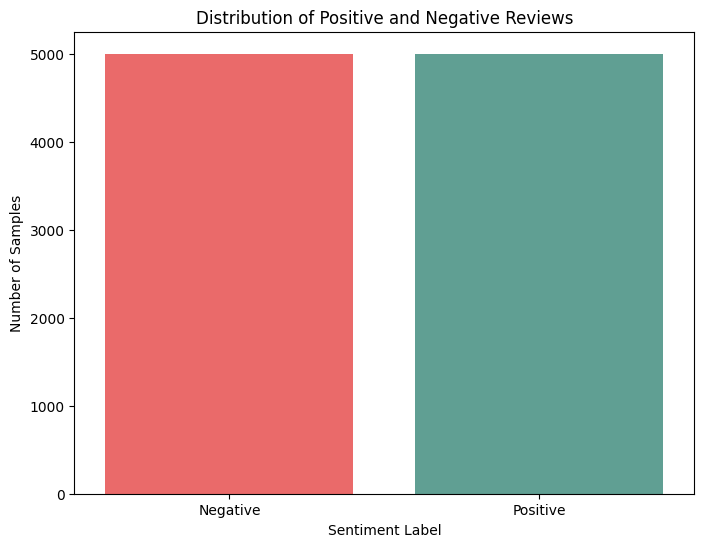

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting the distribution of labels with clearer visualization
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.countplot(x='label', data=df, palette=['#F55','#5A9'])  # Use countplot for direct label counts with custom colors
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


In [8]:
sentences = df.review.values
labels = df.label.values
sentiments = df.sentiment.values

## **3. Load RoBERTa Tokenizer**

In [9]:
from transformers import RobertaTokenizer

print("Loading RoBERTa Tokenizer")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Loading RoBERTa Tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
df.sample(5)

,label,sentiment,review
8299,Positive,1,really really really good game maybe one best ...
8839,Positive,1,pawn think ladder adventure
1477,Negative,0,garbage fucking game
451,Negative,0,boring repetitive even play 2 hour
6558,Positive,1,easily best written game played


In [11]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


Original:  tutorial show key prompt xbox controller even though using k game crashed every single time matter reached first bonfire asked refund game properly patched might try
Tokenized:  ['t', 'utorial', 'Ġshow', 'Ġkey', 'Ġprompt', 'Ġx', 'box', 'Ġcontroller', 'Ġeven', 'Ġthough', 'Ġusing', 'Ġk', 'Ġgame', 'Ġcrashed', 'Ġevery', 'Ġsingle', 'Ġtime', 'Ġmatter', 'Ġreached', 'Ġfirst', 'Ġbon', 'fire', 'Ġasked', 'Ġrefund', 'Ġgame', 'Ġproperly', 'Ġpatched', 'Ġmight', 'Ġtry']
Token IDS:  [90, 48960, 311, 762, 14302, 3023, 8304, 17554, 190, 600, 634, 449, 177, 6050, 358, 881, 86, 948, 1348, 78, 13295, 7051, 553, 12173, 177, 5083, 38471, 429, 860]


In [12]:
input_ids = []

for sent in sentences:
  # Check if sent is not nan before encoding
  if isinstance(sent, str) and sent != 'nan':
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


Original:  tutorial show key prompt xbox controller even though using k game crashed every single time matter reached first bonfire asked refund game properly patched might try
Token IDs:  [0, 90, 48960, 311, 762, 14302, 3023, 8304, 17554, 190, 600, 634, 449, 177, 6050, 358, 881, 86, 948, 1348, 78, 13295, 7051, 553, 12173, 177, 5083, 38471, 429, 860, 2]


Max length: 928
Average length: 54.599579663730985
95th percentile: 222.0


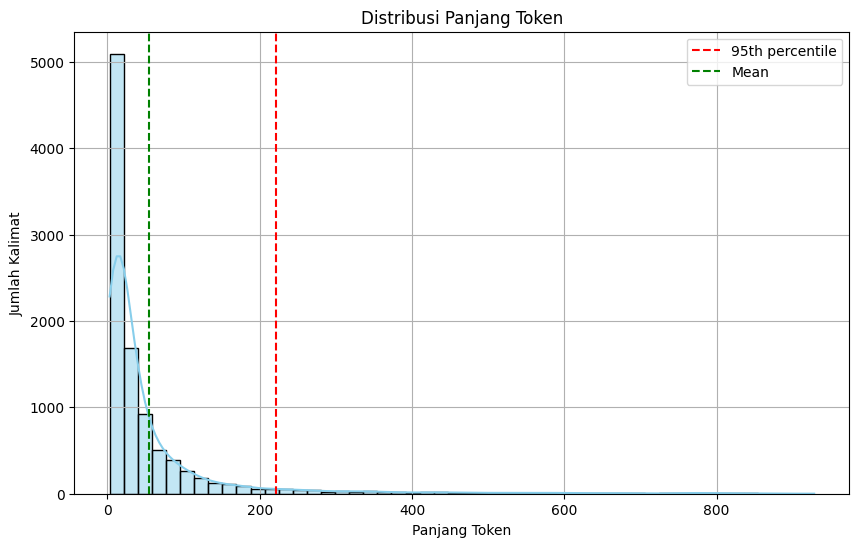

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Hitung panjang setiap tokenized input
lengths = [len(ids) for ids in input_ids]

# Statistik dasar
print("Max length:", np.max(lengths))
print("Average length:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.axvline(np.percentile(lengths, 95), color='red', linestyle='--', label='95th percentile')
plt.axvline(np.mean(lengths), color='green', linestyle='--', label='Mean')
plt.title('Distribusi Panjang Token')
plt.xlabel('Panjang Token')
plt.ylabel('Jumlah Kalimat')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Upper Bound:", upper_bound)

avg_input_id_length = math.ceil(upper_bound)


Q1: 9.0
Q3: 53.0
IQR: 44.0
Upper Bound: 119.0


In [15]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 512

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 119 values
Padding token: "<pad>", ID: 1
Done


In [16]:
input_ids[80]

array([    0,  9029,   202, 17554,   323,  1591,  2085,   323, 17554,
       13523,   910, 14609, 19978,  2399, 22571,     2,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [17]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)


## **4. Persiapkan data**

In [18]:
from sklearn.model_selection import train_test_split

# Sinkronisasi awal
num_samples = min(len(input_ids), len(sentiments), len(attention_mask))
input_ids = input_ids[:num_samples]
sentiments = sentiments[:num_samples]
attention_mask = attention_mask[:num_samples]

# Split pertama: train-test
train_input, test_input, train_sentiments, test_sentiments, train_mask, test_mask = train_test_split(
    input_ids,
    sentiments,
    attention_mask,
    stratify=sentiments,
    random_state=2017,
    test_size=0.1
)

# Split kedua: train-validation
train_input, validation_input, train_sentiments, validation_sentiments, train_mask, validation_mask = train_test_split(
    train_input,
    train_sentiments,
    train_mask,
    stratify=train_sentiments,
    random_state=2017,
    test_size=0.15
)


In [19]:
from collections import Counter

print("Train:", Counter(train_sentiments))
print("Validation:", Counter(validation_sentiments))
print("Test:", Counter(test_sentiments))


Train: Counter({np.int64(0): 3825, np.int64(1): 3818})
Validation: Counter({np.int64(0): 675, np.int64(1): 674})
Test: Counter({np.int64(0): 500, np.int64(1): 500})


<ipython-input-20-6b5835b518d1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#5A9', '#F55'])  # Use countplot for direct label counts with custom colors


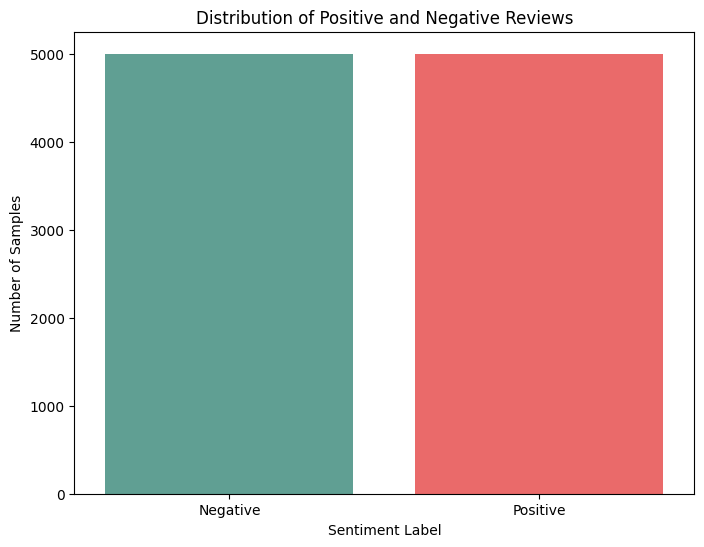

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of labels with clearer visualization
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.countplot(x='label', data=df, palette=['#5A9', '#F55'])  # Use countplot for direct label counts with custom colors
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.show()


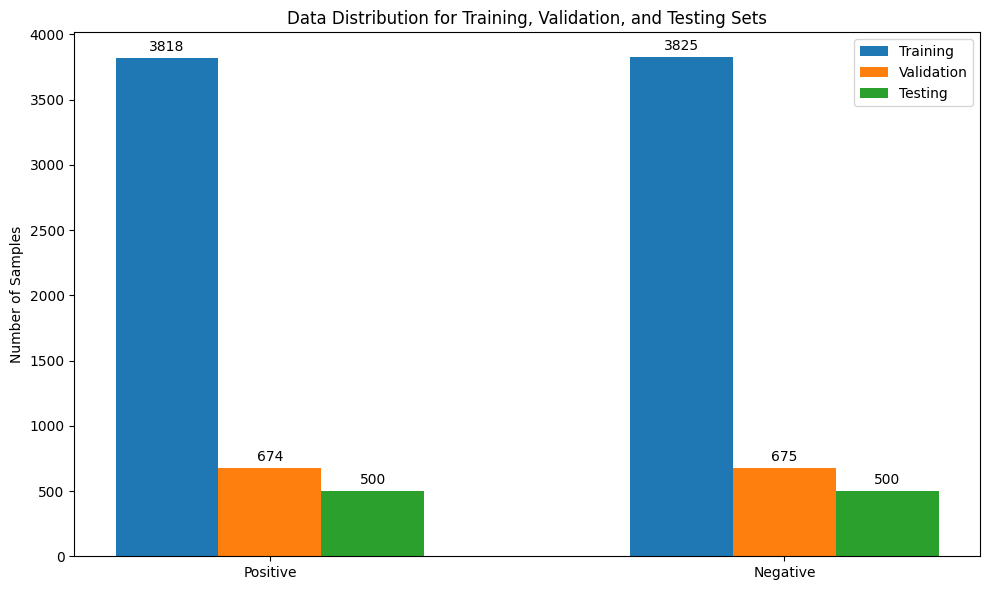

In [21]:

import matplotlib.pyplot as plt
import numpy as np


# Data for the plot (replace with your actual data)
data = {
    'Training': {'Positive': len(train_sentiments[train_sentiments == 1]), 'Negative': len(train_sentiments[train_sentiments == 0])},
    'Validation': {'Positive': len(validation_sentiments[validation_sentiments == 1]), 'Negative': len(validation_sentiments[validation_sentiments == 0])},
    'Testing': {'Positive': len(test_sentiments[test_sentiments == 1]), 'Negative': len(test_sentiments[test_sentiments == 0])}
}

# Create the bar plot
labels = ['Positive', 'Negative']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data['Training'].values(), width, label='Training')
rects2 = ax.bar(x, data['Validation'].values(), width, label='Validation')
rects3 = ax.bar(x + width, data['Testing'].values(), width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Data Distribution for Training, Validation, and Testing Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

In [22]:

# Calculate the number of samples for each label in each dataset
train_df = pd.DataFrame({'label': train_sentiments})
validation_df = pd.DataFrame({'label': validation_sentiments})
test_df = pd.DataFrame({'label': test_sentiments})

train_counts = train_df['label'].value_counts()
validation_counts = validation_df['label'].value_counts()
test_counts = test_df['label'].value_counts()


# Print the counts for each dataset
print("Training Data:")
print(train_counts)
print("\nValidation Data:")
print(validation_counts)
print("\nTesting Data:")
print(test_counts)

# Create a summary table
summary_data = {'Dataset': ['Training', 'Validation', 'Testing'],
                'Positive': [train_counts.get(1, 0), validation_counts.get(1, 0), test_counts.get(1, 0)],
                'Negative': [train_counts.get(0, 0), validation_counts.get(0, 0), test_counts.get(0, 0)]}
summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
summary_df

Training Data:
label
0    3825
1    3818
Name: count, dtype: int64

Validation Data:
label
0    675
1    674
Name: count, dtype: int64

Testing Data:
label
0    500
1    500
Name: count, dtype: int64

Summary Table:


,Dataset,Positive,Negative
0,Training,3818,3825
1,Validation,674,675
2,Testing,500,500


In [23]:
train_input = torch.tensor(train_input)
train_sentiments = torch.tensor(train_sentiments)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_sentiments = torch.tensor(validation_sentiments)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_sentiments = torch.tensor(test_sentiments)
test_mask = torch.tensor(test_mask)

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_data = TensorDataset(train_input, train_mask, train_sentiments)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_sentiments)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_sentiments)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **5. Persiapkan model pre-trained RoBERTa**

In [25]:
from transformers import RobertaForSequenceClassification, RobertaConfig
from torch.optim import AdamW  # Tetap sama

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
params = list(model.named_parameters())

print("The RoBERTa model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.
==== Embedding Layer ====
roberta.embeddings.word_embeddings.weight                    (50265, 768)
roberta.embeddings.position_embeddings.weight                  (514, 768)
roberta.embeddings.token_type_embeddings.weight                  (1, 768)
roberta.embeddings.LayerNorm.weight                                (768,)
roberta.embeddings.LayerNorm.bias                                  (768,)
==== First Transformers ====
roberta.encoder.layer.0.attention.self.query.weight            (768, 768)
roberta.encoder.layer.0.attention.self.query.bias                  (768,)
roberta.encoder.layer.0.attention.self.key.weight              (768, 768)
roberta.encoder.layer.0.attention.self.key.bias                    (768,)
roberta.encoder.layer.0.attention.self.value.weight            (768, 768)
roberta.encoder.layer.0.attention.self.value.bias                  (768,)
roberta.encoder.layer.0.attention.output.dense.weight          (768, 768)
rob

In [27]:
learning_rate = 1e-5;
optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = 1e-8
)

In [28]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [29]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## **6. Training RoBERTa**

======= Epoch 1 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:44
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.6122
   Training epoch took: 0:02:17

Running Validation...
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       675
           1       0.83      0.78      0.81       674

    accuracy                           0.81      1349
   macro avg       0.81      0.81      0.81      1349
weighted avg       0.81      0.81      0.81      1349

   MCC (Validation): 0.6212
   Confusion Matrix (Validation):
      TN: 564, FP: 111, FN: 145, TP: 529


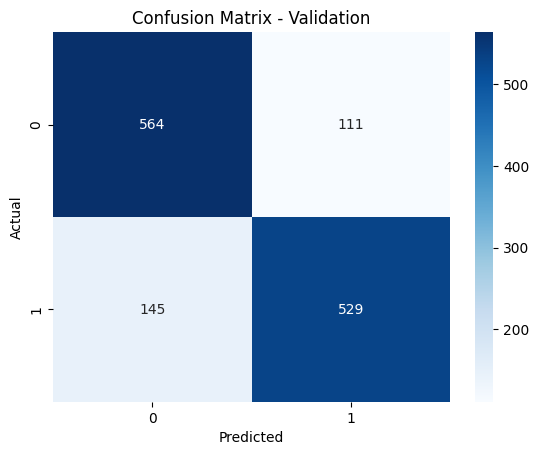

   Validation Accuracy: 0.8098
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       500
           1       0.80      0.79      0.80       500

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

   MCC (Testing): 0.5940
   Confusion Matrix (Testing):
      TN: 401, FP: 99, FN: 104, TP: 396


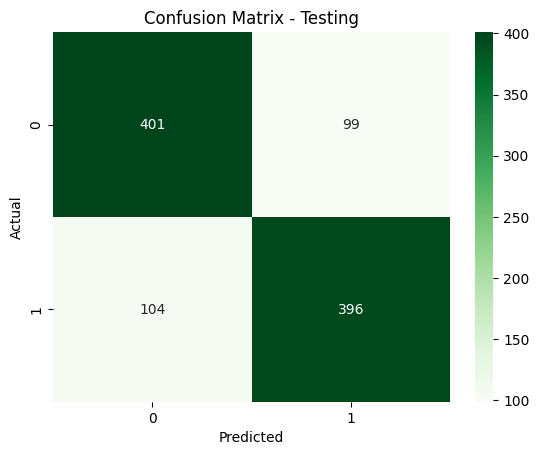

   Test Accuracy: 0.7977
   Testing took: 0:00:07

======= Epoch 2 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.3777
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       675
           1       0.90      0.78      0.83       674

    accuracy                           0.85      1349
   macro avg       0.85      0.85      0.85      1349
weighted avg       0.85      0.85      0.85      1349

   MCC (Validation): 0.6984
   Confusion Matrix (Validation):
      TN: 618, FP: 57, FN: 151, TP: 523


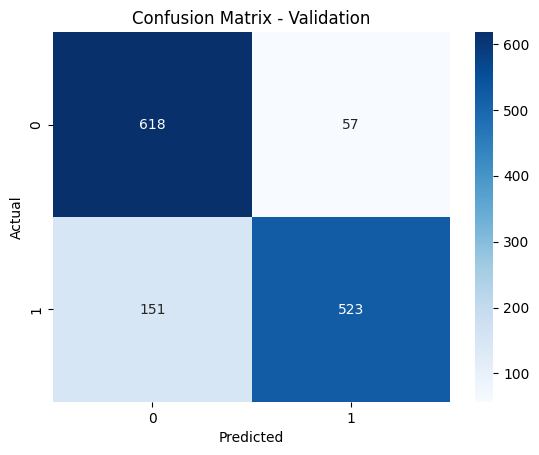

   Validation Accuracy: 0.8439
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       500
           1       0.89      0.80      0.84       500

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000

   MCC (Testing): 0.7075
   Confusion Matrix (Testing):
      TN: 451, FP: 49, FN: 99, TP: 401


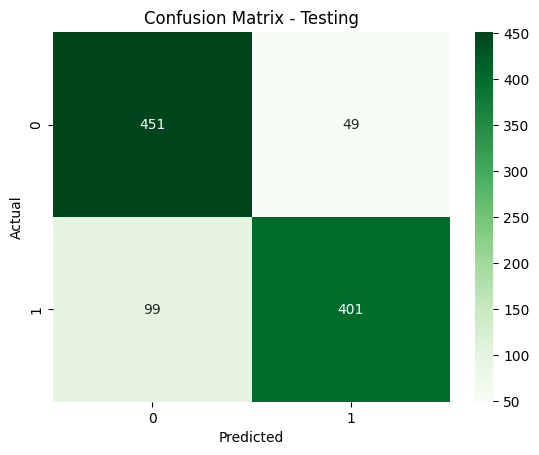

   Test Accuracy: 0.8520
   Testing took: 0:00:06

======= Epoch 3 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.3070
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       675
           1       0.88      0.88      0.88       674

    accuracy                           0.88      1349
   macro avg       0.88      0.88      0.88      1349
weighted avg       0.88      0.88      0.88      1349

   MCC (Validation): 0.7509
   Confusion Matrix (Validation):
      TN: 591, FP: 84, FN: 84, TP: 590


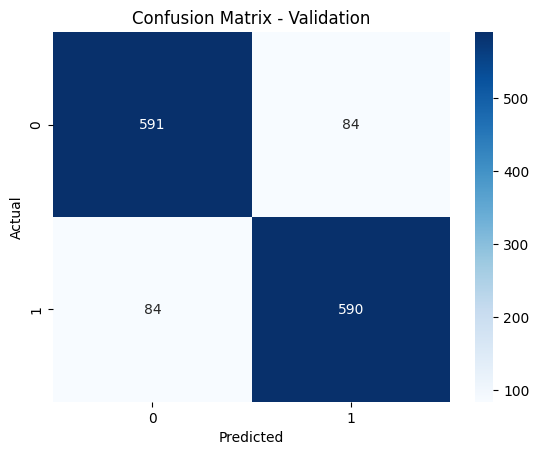

   Validation Accuracy: 0.8639
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       500
           1       0.87      0.90      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000

   MCC (Testing): 0.7704
   Confusion Matrix (Testing):
      TN: 434, FP: 66, FN: 49, TP: 451


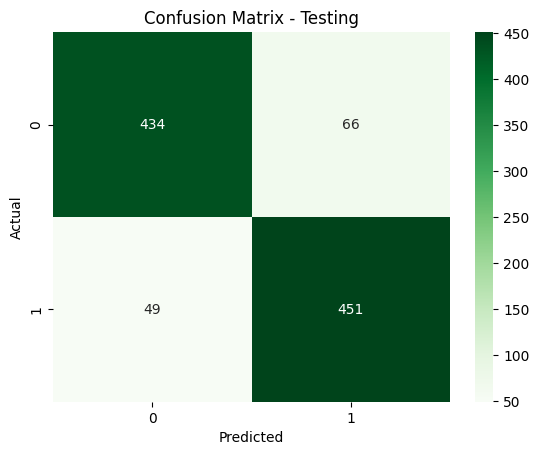

   Test Accuracy: 0.8836
   Testing took: 0:00:06

======= Epoch 4 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.2615
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.86      0.92      0.88       675
           1       0.91      0.85      0.88       674

    accuracy                           0.88      1349
   macro avg       0.88      0.88      0.88      1349
weighted avg       0.88      0.88      0.88      1349

   MCC (Validation): 0.7631
   Confusion Matrix (Validation):
      TN: 618, FP: 57, FN: 104, TP: 570


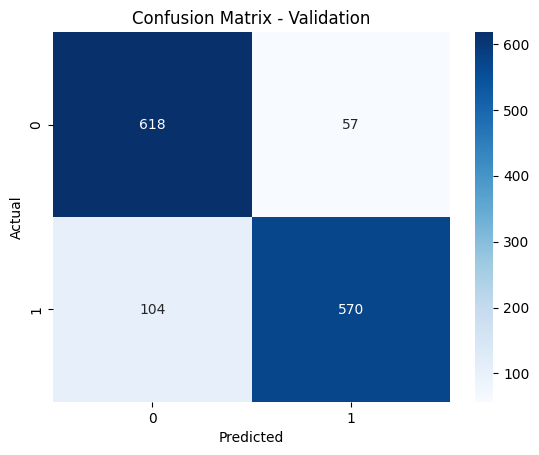

   Validation Accuracy: 0.8773
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       500
           1       0.90      0.87      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

   MCC (Testing): 0.7805
   Confusion Matrix (Testing):
      TN: 454, FP: 46, FN: 64, TP: 436


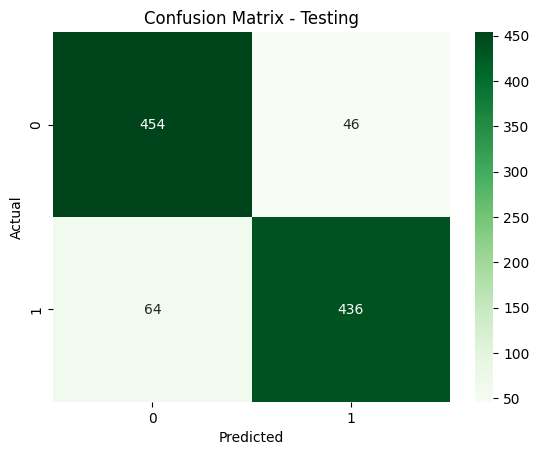

   Test Accuracy: 0.8891
   Testing took: 0:00:06

======= Epoch 5 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.2362
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       675
           1       0.91      0.88      0.89       674

    accuracy                           0.89      1349
   macro avg       0.89      0.89      0.89      1349
weighted avg       0.89      0.89      0.89      1349

   MCC (Validation): 0.7854
   Confusion Matrix (Validation):
      TN: 613, FP: 62, FN: 83, TP: 591


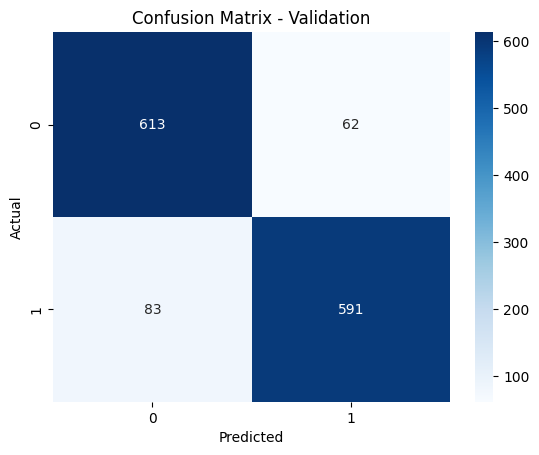

   Validation Accuracy: 0.8886
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       500
           1       0.89      0.89      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

   MCC (Testing): 0.7840
   Confusion Matrix (Testing):
      TN: 445, FP: 55, FN: 53, TP: 447


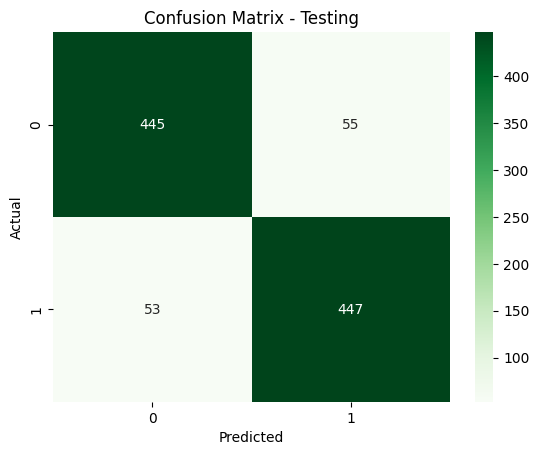

   Test Accuracy: 0.8904
   Testing took: 0:00:06

======= Epoch 6 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.2080
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       675
           1       0.91      0.88      0.89       674

    accuracy                           0.89      1349
   macro avg       0.90      0.89      0.89      1349
weighted avg       0.90      0.89      0.89      1349

   MCC (Validation): 0.7898
   Confusion Matrix (Validation):
      TN: 613, FP: 62, FN: 80, TP: 594


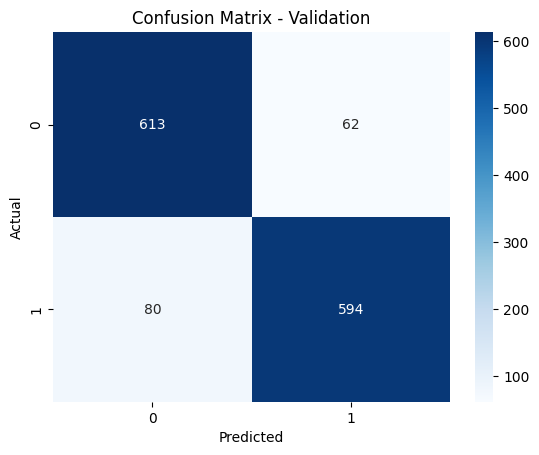

   Validation Accuracy: 0.8824
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       500
           1       0.90      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

   MCC (Testing): 0.7921
   Confusion Matrix (Testing):
      TN: 452, FP: 48, FN: 56, TP: 444


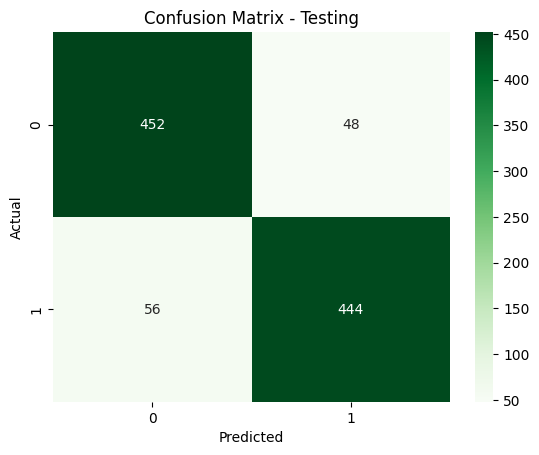

   Test Accuracy: 0.8949
   Testing took: 0:00:06

======= Epoch 7 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.1976
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       675
           1       0.91      0.88      0.89       674

    accuracy                           0.89      1349
   macro avg       0.89      0.89      0.89      1349
weighted avg       0.89      0.89      0.89      1349

   MCC (Validation): 0.7884
   Confusion Matrix (Validation):
      TN: 614, FP: 61, FN: 82, TP: 592


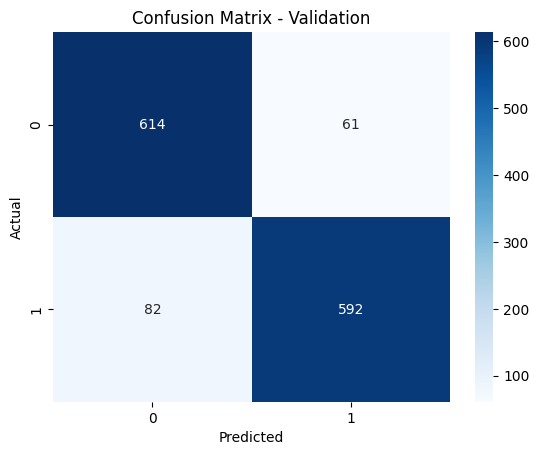

   Validation Accuracy: 0.8901
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       500
           1       0.90      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

   MCC (Testing): 0.7980
   Confusion Matrix (Testing):
      TN: 452, FP: 48, FN: 53, TP: 447


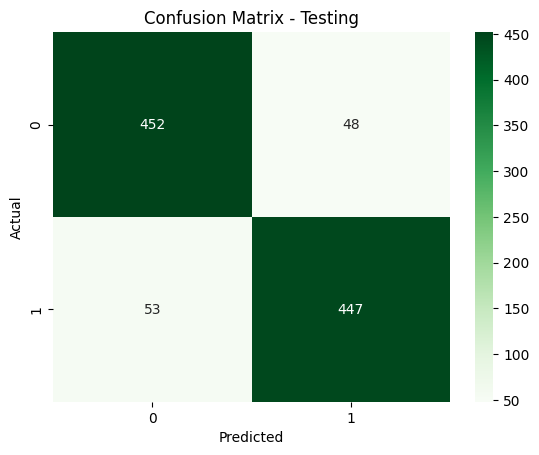

   Test Accuracy: 0.8984
   Testing took: 0:00:06

======= Epoch 8 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.1808
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       675
           1       0.89      0.90      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.7924
   Confusion Matrix (Validation):
      TN: 604, FP: 71, FN: 69, TP: 605


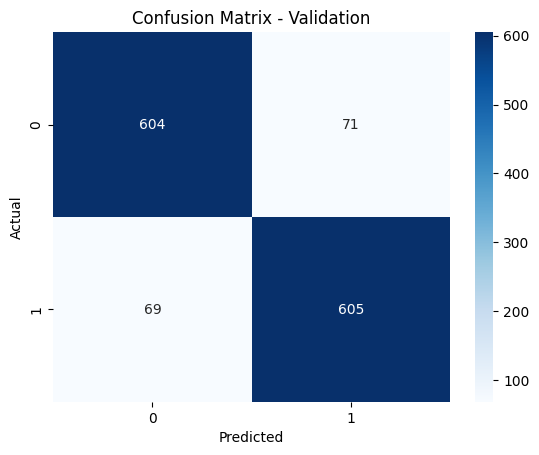

   Validation Accuracy: 0.8838
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       500
           1       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

   MCC (Testing): 0.7943
   Confusion Matrix (Testing):
      TN: 442, FP: 58, FN: 45, TP: 455


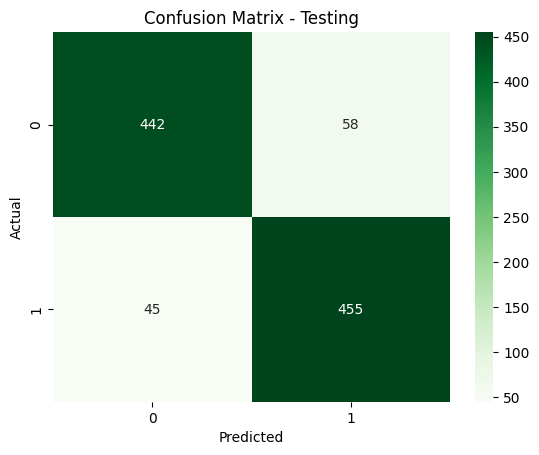

   Test Accuracy: 0.8965
   Testing took: 0:00:06

======= Epoch 9 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.1701
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       675
           1       0.89      0.91      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.7912
   Confusion Matrix (Validation):
      TN: 597, FP: 78, FN: 63, TP: 611


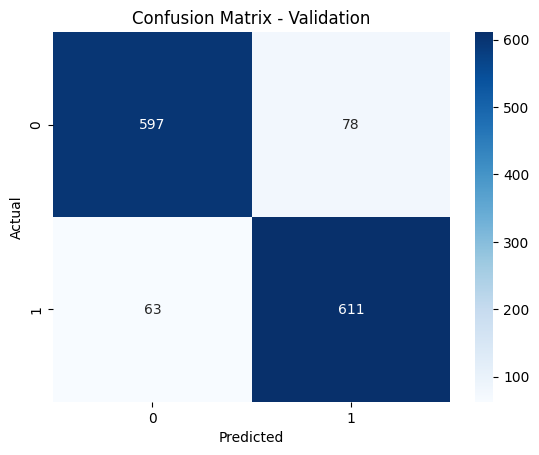

   Validation Accuracy: 0.8831
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       500
           1       0.88      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

   MCC (Testing): 0.7945
   Confusion Matrix (Testing):
      TN: 440, FP: 60, FN: 43, TP: 457


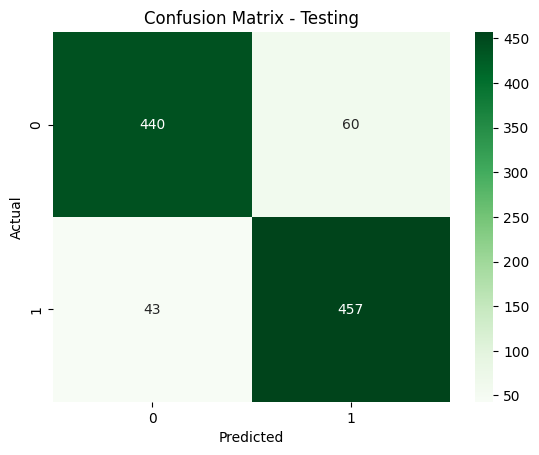

   Test Accuracy: 0.8959
   Testing took: 0:00:06

======= Epoch 10 / 10 =======
Training...
Batch    40 of   120.     Elapsed: 0:00:46
Batch    80 of   120.     Elapsed: 0:01:32
   Average training loss: 0.1696
   Training epoch took: 0:02:18

Running Validation...
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       675
           1       0.89      0.90      0.90       674

    accuracy                           0.90      1349
   macro avg       0.90      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349

   MCC (Validation): 0.7940
   Confusion Matrix (Validation):
      TN: 602, FP: 73, FN: 66, TP: 608


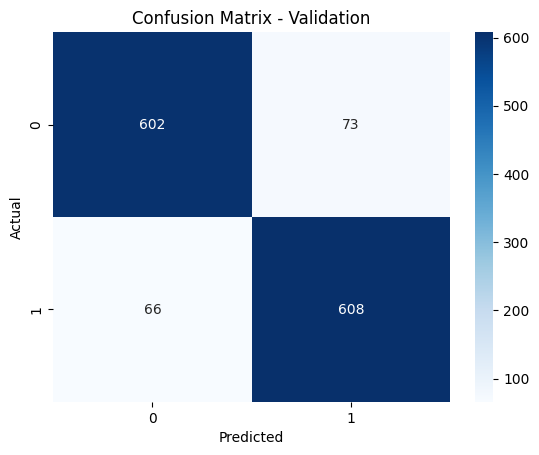

   Validation Accuracy: 0.8845
   Validation took: 0:00:09

Running Testing...
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       500
           1       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

   MCC (Testing): 0.8002
   Confusion Matrix (Testing):
      TN: 444, FP: 56, FN: 44, TP: 456


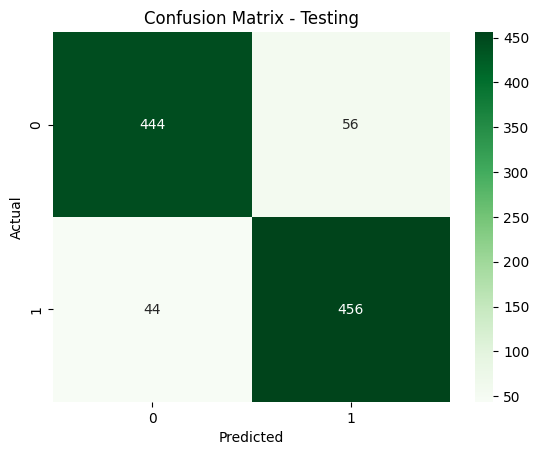

   Test Accuracy: 0.8994
   Testing took: 0:00:06

Log training per epoch disimpan di 'training_logs.csv'
Training complete!
Total training time: 0:23:02


In [31]:
import random
import time
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

# Setup seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Simpan history dan log
loss_values = []
validation_accuracies = []
test_accuracies = []
epoch_logs = []

total_training_time = 0
model.to(device)

for epoch_i in range(0, epochs):
    print("======= Epoch {:} / {:} =======".format(epoch_i + 1, epochs))
    print("Training...")

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    epoch_training_time = time.time() - t0
    total_training_time += epoch_training_time

    print("   Average training loss: {0:.4f}".format(avg_train_loss))
    print("   Training epoch took: {:}".format(format_time(epoch_training_time)))

    # ============================
    #        VALIDATION
    # ============================
    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()

    eval_accuracy = 0
    nb_eval_steps = 0
    all_preds_val = []
    all_labels_val = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        preds = np.argmax(logits, axis=1)
        all_preds_val.extend(preds)
        all_labels_val.extend(label_ids)

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    validation_accuracies.append(avg_val_accuracy)

    print(classification_report(all_labels_val, all_preds_val))

    mcc_val = matthews_corrcoef(all_labels_val, all_preds_val)
    print("   MCC (Validation): {:.4f}".format(mcc_val))

    cm_val = confusion_matrix(all_labels_val, all_preds_val)
    print("   Confusion Matrix (Validation):")
    try:
        tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
        print(f"      TN: {tn_val}, FP: {fp_val}, FN: {fn_val}, TP: {tp_val}")
    except:
        tn_val = fp_val = fn_val = tp_val = None
        print("      (Multi-class confusion matrix)")

    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Validation')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("   Validation Accuracy: {0:.4f}".format(avg_val_accuracy))
    print("   Validation took: {:}".format(format_time(time.time() - t0)))

    # ============================
    #          TESTING
    # ============================
    print("\nRunning Testing...")
    t0 = time.time()
    model.eval()

    test_accuracy = 0
    nb_test_steps = 0
    all_preds_test = []
    all_labels_test = []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        test_accuracy += tmp_test_accuracy
        nb_test_steps += 1

        preds = np.argmax(logits, axis=1)
        all_preds_test.extend(preds)
        all_labels_test.extend(label_ids)

    avg_test_accuracy = test_accuracy / nb_test_steps
    test_accuracies.append(avg_test_accuracy)

    print(classification_report(all_labels_test, all_preds_test))

    mcc_test = matthews_corrcoef(all_labels_test, all_preds_test)
    print("   MCC (Testing): {:.4f}".format(mcc_test))

    cm_test = confusion_matrix(all_labels_test, all_preds_test)
    print("   Confusion Matrix (Testing):")
    try:
        tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
        print(f"      TN: {tn_test}, FP: {fp_test}, FN: {fn_test}, TP: {tp_test}")
    except:
        tn_test = fp_test = fn_test = tp_test = None
        print("      (Multi-class confusion matrix)")

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix - Testing')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("   Test Accuracy: {0:.4f}".format(avg_test_accuracy))
    print("   Testing took: {:}\n".format(format_time(time.time() - t0)))

    # ============================
    #     LOG PER EPOCH
    # ============================
    epoch_logs.append({
        "epoch": epoch_i + 1,
        "train_loss": avg_train_loss,
        "val_accuracy": avg_val_accuracy,
        "val_mcc": mcc_val,
        "test_accuracy": avg_test_accuracy,
        "test_mcc": mcc_test,
        "val_tn": tn_val,
        "val_fp": fp_val,
        "val_fn": fn_val,
        "val_tp": tp_val,
        "test_tn": tn_test,
        "test_fp": fp_test,
        "test_fn": fn_test,
        "test_tp": tp_test
    })

# Save log ke CSV
df_logs = pd.DataFrame(epoch_logs)
df_logs.to_csv("training_logs.csv", index=False)
print("Log training per epoch disimpan di 'training_logs.csv'")

print("Training complete!")
print("Total training time: {:}".format(format_time(total_training_time)))


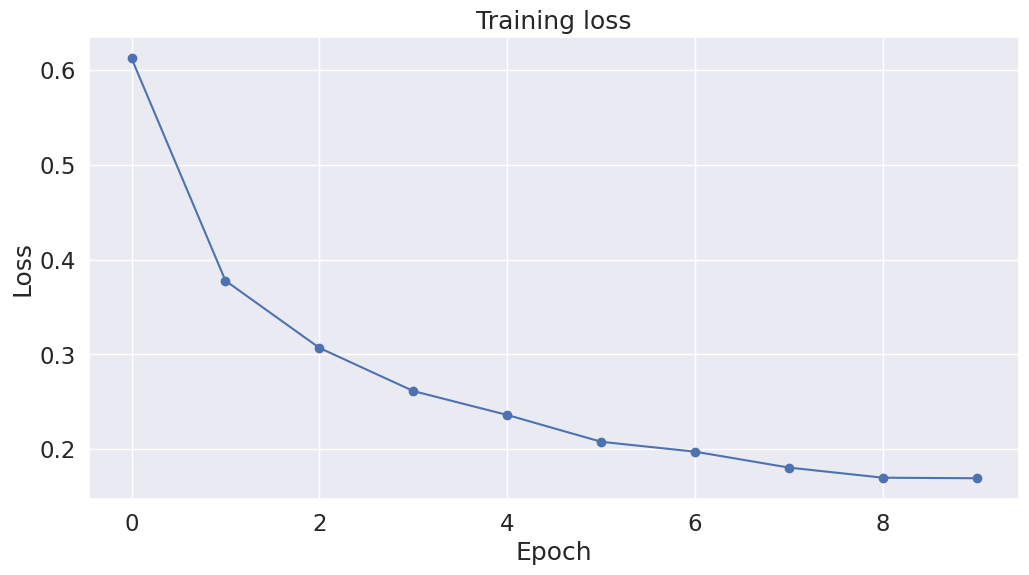

In [32]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## **7. Predict dan Evaluate**

In [33]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,

                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,000 test sentences
 DONE.


In [34]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.800


In [35]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)


ACC: 0.900



Hyperparameters:
- Learning Rate: 1e-05
- Batch Size: 64
- Epochs: 10
MCC: 0.80
ACC: 0.90
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       500
           1       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



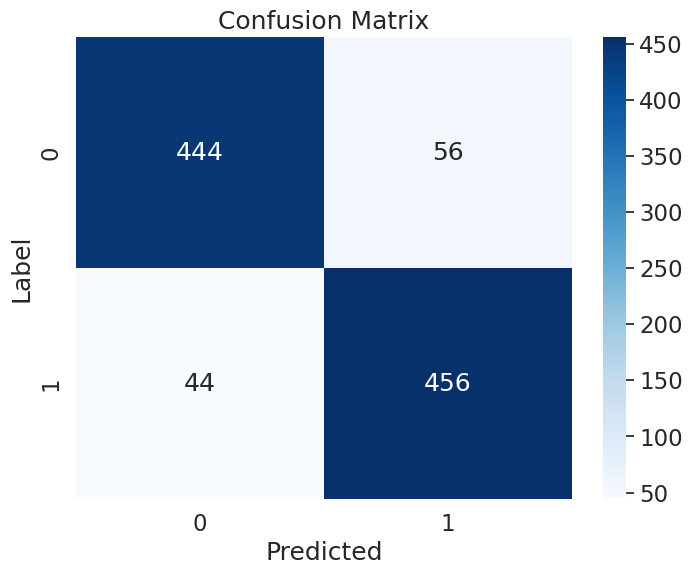

In [36]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Additional information you might want to display:
# * Training time per epoch
# * Hyperparameters used (learning rate, batch size, epochs, etc.)
# * Number of training examples
# * Number of validation examples
# * Number of test examples
# * Model architecture details
# * Other relevant metrics, e.g., precision, recall, F1-score (if applicable)

# Example of displaying hyperparameters
print("\nHyperparameters:")
print(f"- Learning Rate: {learning_rate}")  # Replace with your actual learning rate
print(f"- Batch Size: {batch_size}") # Replace with your actual batch size
print(f"- Epochs: {epochs}") # Replace with your actual epoch number

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)
print("MCC: %.2f" % mcc)

acc = accuracy_score(flat_true_labels, flat_prediction)
print("ACC: %.2f" % acc)

# Generate classification report
print(classification_report(flat_true_labels, flat_prediction))

# Generate and plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.title("Confusion Matrix")
plt.show()